In [1]:
from bayes import Bayes         # for Bayes
import numpy as np              # for linspace
import scipy.stats as stats     # for binom, uniform
import matplotlib.pyplot as plt # for plot

%matplotlib inline

# Objectives [morning]


- Define and explain prior, likelihood, and posterior (part 1)

- Analyze an A/B test with the Bayesian approach (part 2.1)

- Explain what a conjugate prior is and how it applies to A/B testing (part 2.2)

- Explain the difference between Frequentist and Bayesian A/B tests (part 3)


# 1. Bayes' Theorem [review]

This following formula is the underpinning of all Bayesian Analysis.
It is **very important** to understand what each of the terms are. Do not
move on until you have read and understood this section.

![bayes formula](images/bayes_formula.png)

## 1.1. Components of the Bayes' theorem
**Prior Probability**:
- A PMF / PDF representing your initial beliefs about the parameter(s)
- The initial belief is less represented in the posterior as more data is incorporated

**Likelihood**:
- The probability of observing the data given the parameter(s)
- i.e. What is the likelihood of 3 Heads in a row given the probability of heads is 0.7?

**Posterior Probability**:
- The product of prior and likelihood (Bayesian-update)
- The posterior probability becomes the prior of the next Bayesian-update

**Normalizing Constant**:
- The probability of observing the data. 
- In Bayesian analysis, this term ensures the sum of all probabilities is 1

## 1.1. The "diachronic" interpretation

In [Think Bayes, p. 5](http://www.greenteapress.com/thinkbayes/thinkbayes.pdf) we find:

> There is another way to think of Bayes’s theorem: it gives us a way to update the probability of a hypothesis, H, in light of some body of data, D.
This way of thinking about Bayes’s theorem is called the diachronic interpretation. “Diachronic” means that something is happening over time; in this case the probability of the hypotheses changes, over time, as we see new data.

>Rewriting Bayes’s theorem with H and D yields:

> $$ p(H \mid D) = \frac {p(H) \: p(D \mid H)} {p(D)}$$

> In this interpretation, each term has a name:

>- $p(H)$ is the probability of the hypothesis before we see the data, called the prior probability, or just prior.
>- $p(H \mid D)$ is what we want to compute, the probability of the hypothesis after we see the data, called the posterior.
>- $p(D \mid H)$ is the probability of the data under the hypothesis, called the likelihood.
>- $p(D)$ is the probability of the data under any hypothesis, called the normalizing constant.



If we overlook that normalizing constant, what comes up is a relation between prior, likelihood and posterior.

$$ posterior \sim likelihood \times prior $$


# 2. A/B testing with a Bayesian approach

**We are about to use that diachronic interpretation to iteratively compute the distribution model of click-through rate after we see some clicks.**

## 2.1. Applying the `power-bayes` assignment

Remember that pair assignment in [power-bayes](https://github.com/zipfian/power-bayesian/blob/master/pair.md) ? Let's apply that kind of reasoning to A/B testing the Click Through Rate of two websites.

Let's first define a set of possible CTR values $\Omega$.

CTR is a float value between 0 and 1, let's choose to work on a discrete subset of $[0,1]$.

In [2]:
ctr_omega = np.linspace(0, 1, 101)

Now let's think about what could be a **prior** on CTR ? With no data, all possible CTR could be consider equally likely. Meaning... uniform.

In [3]:
ctr_priors = { k:stats.uniform.pdf(k, loc=0, scale=1) for k in ctr_omega }

In [4]:
def ctr_likelihood(data, x):
    # what is the likelihood of drawing data
    # given that CTR is x
    # data = 0 for non-click, 1 for click
    return(stats.binom.pmf(data, 1, x))

I'm not creating an instance of that same `Bayes` object you used.

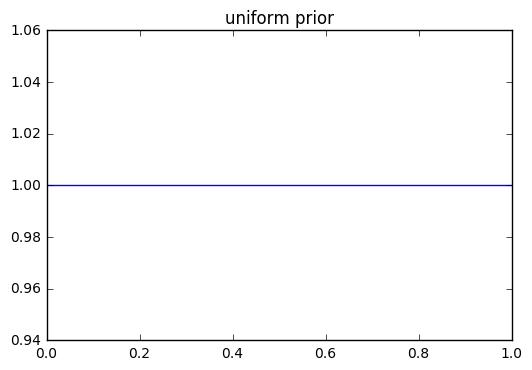

In [5]:
bayes = Bayes(ctr_priors.copy(), ctr_likelihood)
bayes.plot(title="uniform prior")

Now let's "feed" that process with new incoming data. Each time a click goes through or not, we will update our `Bayes` object with `1` (click) or `0` (no click).

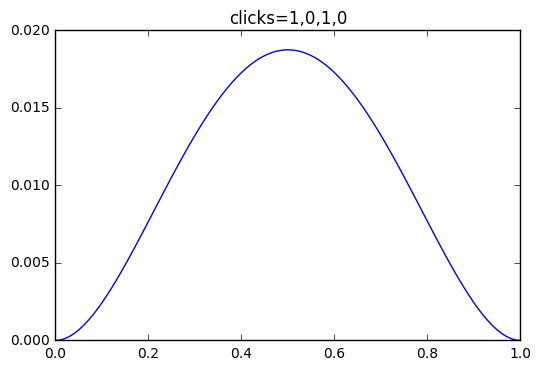

In [6]:
bayes.update(1) # click
bayes.update(0) # no click
bayes.update(1) # click
bayes.update(0) # no click

bayes.plot(title="clicks=1,0,1,0")

Let's create a function to do that nicely...

In [7]:
def feed_bayes_and_plot(bayes, data_sequence):
    N = len(data_sequence)
    
    fig, axs = plt.subplots(1, N, figsize=(16, 3))
    
    # for each new data point
    for i, ax in enumerate(axs.flatten()):
        bayes.update(data_sequence[i])
        sorted_keys = sorted(bayes.prior.keys())
        sorted_probs = [bayes.prior[key] for key in sorted_keys]
        ax.plot(sorted_keys, sorted_probs)
        ax.set_title(",".join(map(str,data_sequence[0:i+1])))
        ax.get_yaxis().set_ticks([])

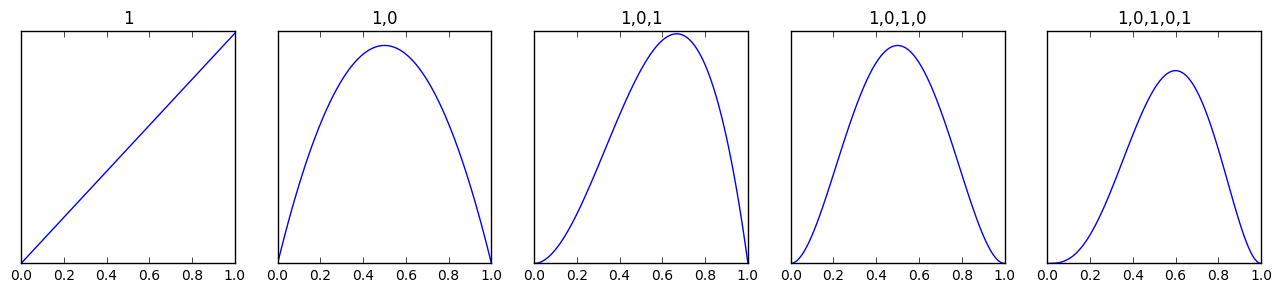

In [8]:
clicks_siteA = [1,0,1,0,1]

bayesA = Bayes(ctr_priors.copy(), ctr_likelihood)
feed_bayes_and_plot(bayesA, clicks_siteA)

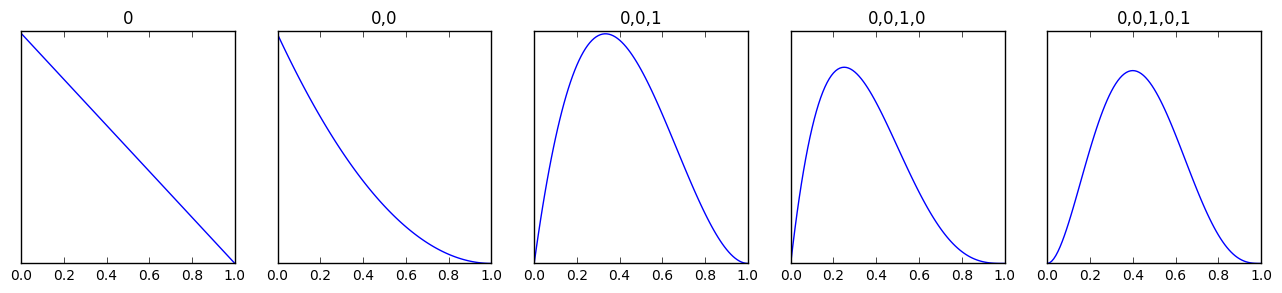

In [9]:
clicks_siteB = [0,0,1,0,1]

bayesB = Bayes(ctr_priors.copy(), ctr_likelihood)
feed_bayes_and_plot(bayesB, clicks_siteB)

## 2.2. Conjugate Priors

We already see Bayes' theorem as a relation between posterior, prior and likelihood:

$$ posterior \sim likelihood \times prior $$

### 2.2.1 Definition

Prior distribution models, and likelihood distribution models are parametric (Normal, Gamma, Beta...). 

Pairs of distribution families for (likelihood, prior) so that the resulting **posterior distribution belongs to the same parametric family as the prior distribution** with different parameters, are called **Conjugate Priors**.

### 2.2.2. Example

**Example** with [Beta](https://en.wikipedia.org/wiki/Beta_distribution) prior and [Binomial](https://en.wikipedia.org/wiki/Binomial_distribution) likelihood:

#### Choosing a prior model

We choose to represent the CTR distribution model as a Beta prior. With:
- $p$ the conversion rate (between 0 and 1, representing the probability of a click)
- $\alpha, \beta$ are the shape parameters ($\alpha$ = 1 + number of conversions, $\beta$ = 1 + number of non conversions)

$ Beta(p ; \alpha, \beta) = \frac {p^{\alpha-1} \: (1-p)^{\beta-1}} {B(\alpha,\beta)} $

**Note:** $\alpha = \beta = 1$ gives you the *uniform distribution*.

In [10]:
ctr_omega = np.linspace(0, 1, 101)
ctr_priors = { k:stats.beta.pdf(k, a=1, b=1) for k in ctr_omega }

#### Choosing a likelihood model

We choose to represent the likelihood of a CTR given some observation. With :
- $p$ the hypothetical conversion rate,
- $n$ number of draws,
- $k$ some observed value:

$ Binomial(k;n,p) = \binom {n} {k} p^k (1-p)^{n-k} $

In [11]:
def ctr_likelihood(data, x):
    # what is the likelihood of drawing data
    # given that CTR is x
    # data = 0 for non-click, 1 for click
    return(stats.binom.pmf(data, 1, x))

#### What does the posterior look like ?

$ posterior = \frac {p^{\alpha-1} \: (1-p)^{\beta-1}} {B(\alpha,\beta)} \times \binom {n} {k} p^k (1-p)^{n-k} $

$ posterior \sim p^{\alpha-1} \: (1-p)^{\beta-1} \times p^k (1-p)^{n-k} $

$ posterior \sim p^{\alpha+k-1} \: (1-p)^{\beta+n-k-1} $

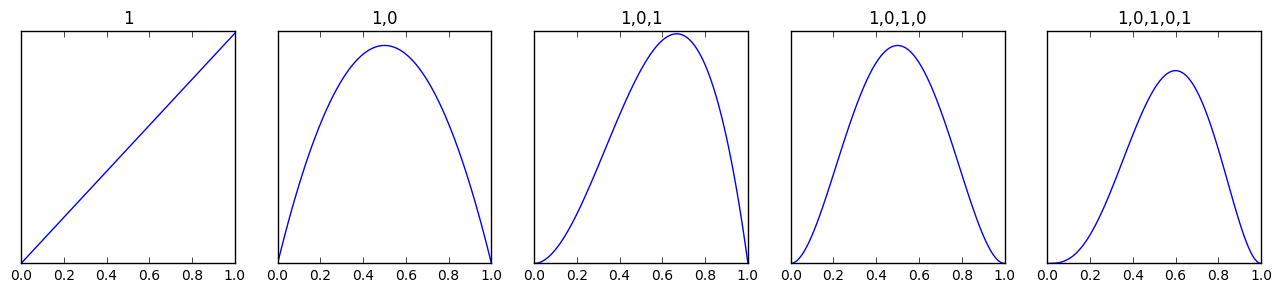

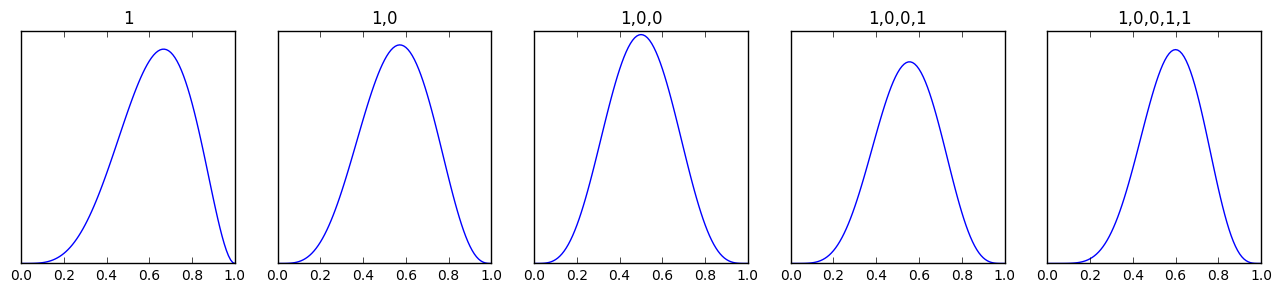

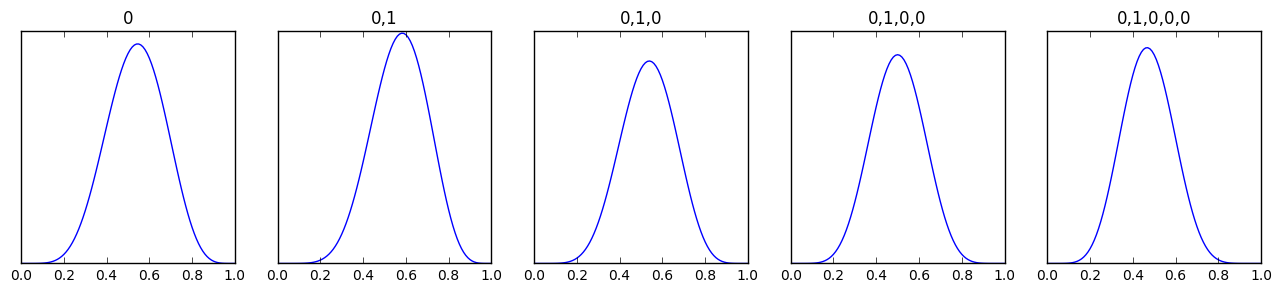

In [12]:
clicks_siteN = [1,0,1,0,1,
                1,0,0,1,1,
                0,1,0,0,0]

bayesN = Bayes(ctr_priors.copy(), ctr_likelihood)

feed_bayes_and_plot(bayesN, clicks_siteN[0:5])
feed_bayes_and_plot(bayesN, clicks_siteN[5:10])
feed_bayes_and_plot(bayesN, clicks_siteN[10:15])

### 2.2.3. Table of known conjugate priors

Here's a table extracted from [Stats Handouts UChicago](http://galton.uchicago.edu/~eichler/stat24600/Handouts/l06.pdf).

| Likelihood | Prior | Posterior |
| :-: | :-: | :-: |
| Normal | Normal | Normal |
| Poisson | Gamma | Gamma |
| Gamma | Gamma | Gamma |
| Binomial | Beta | Beta |
| Multinomial | Dirichlet | Dirichlet |
| Normal | Gamma | Gamma |

# 3. Bayesian vs Ferquentist A/B testing

## 3.1. Frequentist AB testing process

1. define a metric
2. determine parameters of interest for study (number of observations, power, significance threshold, and so on)
3. run all experiments, without checking results, until number of observations has been achieved
4. calculate p-value associated with hypothesis test
5. report p-value and suggestion for action

The significance is probability of getting result (or more extreme) assuming no effect. Doesn’t tell you how likely it is that a is better than b.

## 3.2. Bayesian AB testing process

1. define a metric, a prior model and likelihood model
2. run test, continually monitor results
3. at any time calculate probability that A > B or vice versa
4. suggest course of action based on probabilities calculated

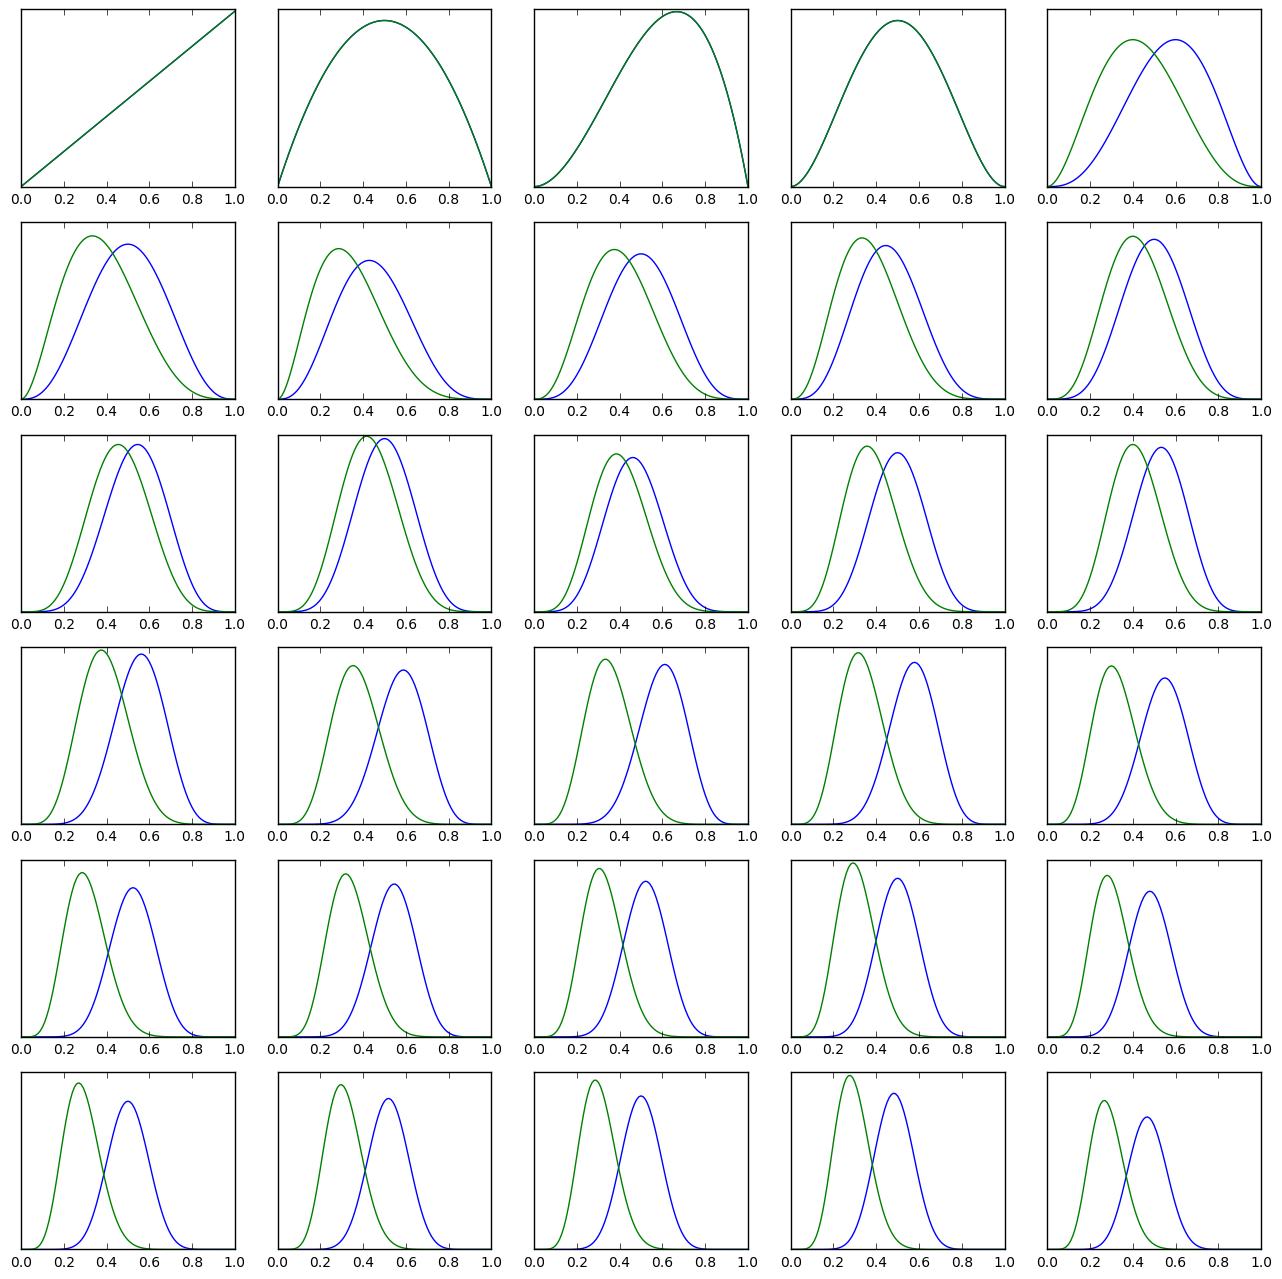

In [13]:
N = 30 # len of both click sequences

clicks_siteA = [1,0,1,0,1,0,0,1,0,1,
                1,0,0,1,1,1,1,1,0,0,
                0,1,0,0,0,1,1,0,0,0]

clicks_siteB = [1,0,1,0,0,0,0,1,0,1,
                1,0,0,0,1,0,0,0,0,0,
                0,1,0,0,0,0,1,0,0,0]

bayesA = Bayes(ctr_priors.copy(), ctr_likelihood)
bayesB = Bayes(ctr_priors.copy(), ctr_likelihood)

fig, axs = plt.subplots(6, 5, figsize=(16, 16))

for i, ax in enumerate(axs.flatten()):
    bayesA.update(clicks_siteA[i])
    bayesB.update(clicks_siteB[i])

    sorted_keys = sorted(ctr_priors.keys())

    sorted_probsA = [bayesA.prior[key] for key in sorted_keys]
    sorted_probsB = [bayesB.prior[key] for key in sorted_keys]

    ax.plot(sorted_keys, sorted_probsA)
    ax.plot(sorted_keys, sorted_probsB)
    ax.get_yaxis().set_ticks([])

In both cases, we consider an ensemble of possible randomly generated universes.

**Frequentist**: The hypothesis is a fixed (though unknown) reality; the observed data follows some random distribution

**Bayesian**: The observed data is a fixed reality; the hypotheses follow some random distribution.

## 3.3. Application of Bayesian A/B testing

we want to know if this is true: 
> conversion rate of site A > conversion rate of site B

we can also answer if this is true: 
> conversion rate of site A > conversion rate of site B + 5%


- Show each website to N people to obtain posterior distribution parameters $\alpha$ = 1 + Clicks and $\beta$ = 1 + N − Clicks for each website.

In [14]:
views_A = 100
clicks_A = 58

views_B = 80
clicks_B = 45

- Simulate: sample from both distributions and find the fraction with CTRA > CTRB => likelihood that A is better than B.

- Can also ask the likelihood that CTRA > CTRB + 5%. Can’t do this with an Frequentist test!!

In [15]:
# let's draw values from those distribution models
sample_size = 10000

# model for A, fed with the right values
A_sample = stats.beta.rvs(1 + clicks_A,
                          1 + views_A - clicks_A,
                          size=sample_size)

# model for B, fed with the right values
B_sample = stats.beta.rvs(1 + clicks_B,
                          1 + views_B - clicks_B,
                          size=sample_size)

# let's find out likelyhood of A is better than B
print sum(A_sample > B_sample) / float(sample_size)

0.5929
